In [37]:
### ---- ---- ---- ---- ---- ---- ###
### Medical Claims Data Generator ###
### ---- ---- ---- ---- ---- ---- ###
#
#
# This program dynamically generates
# comprehensive enrollment data and
# corresponding medical claims data.
#
#
# Plenty of parameters exist to modify
# underlying data generation techniques.
#
#
# Total run time is less than 1 minute.
#
#
# Brett D. Johnson
# September 2, 2020

In [1]:
# Import modules
import requests
import pandas as pd
import numpy as np
import numpy.random as rnd
import uuid
import random
import datetime
import calendar
from dateutil.relativedelta import relativedelta
from itertools import chain, repeat
import matplotlib.pyplot as plt

In [2]:
# Get the 1,000 most common first names from social security website.

url = 'https://www.ssa.gov/cgi-bin/popularnames.cgi'
payload = {'year': '2010', 'top': '1000', 'number': 'p'}
types_dict = {'Rank': int, 'Male name': str, 'Female name': str}

page = requests.post(url, data=payload)
first_names = pd.read_html(page.text)[2].iloc[:-1,:]

for col, col_type in types_dict.items():
    first_names[col] = first_names[col].astype(col_type)

In [3]:
# Get the 1,000 most common last names from census website [download csv to working directory].
# https://www.census.gov/topics/population/genealogy/data/2010_surnames.html

last_names = pd.read_csv('./Names_2010Census.csv').loc[:999, ['rank', 'name', 'prop100k']]

In [27]:
def genClaims(pct, mnths, dat, agefac, mbrHist, toprint='No'):
    
    """
    Function that generates medical claims cost components.

    lambduh -> randomly sets lambda parameter from [0, 1, 2]
    x       -> monthly utilization modeled by Poisson distribution
    y       -> claim severity modeled by Beta distribution with α=2 and β=5
    z       -> individual claim amount modeled by Uniform distribution

    daysfac -> seasonality factor for number of days per month
    agefac  -> dynamic factor in range [1.0, 1.25] based upon member's age
    trend   -> annual trend from input parameter 'pct'
    """
    
    lambduh = random.choices([0, 1, 2], weights=(40,40,20)) # Randomly selects lambda parameter value for Poisson distribution
    x = np.random.poisson(lambduh, 1)
    y = random.betavariate(2, 5)
    z = random.uniform(500, 1500)
    
    daysfac = calendar.monthrange(dat.year, dat.month)[1] / 30
    claims = float(x * y * z) * (mnths > 0)
    trend = (1 + pct)**(mnths/12) - 1

    if toprint == 'Yes':
        print(f'{agefac}\n{daysfac}\n{mnths}\n{trend}\n\n')
    else:
        pass
    
    return round(claims * (1 + trend) * agefac * mbrHist * daysfac, 2), daysfac, agefac, mbrHist, claims, trend+1

In [28]:
class Member:

    """
    Base class from which Subscriber & Dependent objects inherit randomized data.
    """
    
    alphabet = ['0', '1']
    transitions = ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '1']

    bgn = pd.to_datetime('January 01 2016', format='%B %d %Y')
    end = pd.to_datetime('December 31 2020', format='%B %d %Y')

    def __init__(self):
        
        """Initialize class instance."""
        
        self.gender = ''.join(random.choices(['female', 'male'], [6,5], k=1))
        self.lname = ''.join(random.choices(last_names['name'].str.title(), weights=(len(last_names) - last_names['rank'])))
        self.fname = ''.join(random.choices(first_names['%s name' % self.gender.title()].str.title(), weights=(len(first_names) - first_names['Rank'])))
        self.personID = uuid.uuid4().hex[:12]

    def getDob(self, bgn, end, n=1):
            
        """Randomly assign dob between bgn & end dates."""
        
        (divide_by, unit) = (24*60*60*10**9, 'D')
        bgn_u = bgn.value // divide_by
        end_u = end.value // divide_by
        return pd.to_datetime(np.random.randint(bgn_u, end_u, n), unit=unit)

    @classmethod
    def ageFac(cls, age, breakpoint=55):
        
        """Algorithm that calculates age factor for claims data generation."""
        
        floor_val = age // breakpoint
        yrdif_val = age - breakpoint
        modul_val = age % breakpoint
        range_val = 65 - breakpoint
        young_val = (1 - floor_val) + max(0, (range_val - modul_val) / breakpoint)
        oldie_val = 1 + (yrdif_val / breakpoint)
        factr_val = max(young_val, oldie_val)
        return float(factr_val)

    @classmethod
    def genHist(cls):
        
        """Generate monthly enrollment history. 0=inactive, 1=active"""
        
        # Create probability matrix; initialize with zeros
        prob_matrix = {}
        for i in cls.alphabet:
            prob_matrix[i] = {}
            for j in cls.alphabet:
                prob_matrix[i][j] = 0.0

        def rank(c):
            return ord(c) - ord(cls.alphabet[0])

        # Fill matrix with numbers based on transitions list
        T = [rank(c) for c in cls.transitions]
        for (i,j) in zip(T,T[1:]):
            prob_matrix[cls.alphabet[i]][cls.alphabet[j]] += 1

        # Convert to probabilities
        for row in prob_matrix:
            total = sum([prob_matrix[row][column] for column in prob_matrix[row]])
            if total > 0:
                for column in prob_matrix[row]:
                    prob_matrix[row][column] /= total

        # Simulate the data
        n = int((cls.end - cls.bgn)/np.timedelta64(1, 'M'))
        outputseq = rnd.choice(cls.alphabet, None)
        outputlist = [outputseq]
    
        for i in range(n):
            probabilities = [prob_matrix[outputseq[-1]][j] for j in cls.alphabet]
            outputseq += rnd.choice(cls.alphabet, None, False, probabilities)
            outputlist.append(outputseq[i+1])
        return [int(x) for x in outputlist]
    
    @classmethod
    def seqHist(cls, seqlist):

        """Generate cumulative sequence history from genHist() output."""
        
        outputseq = []
        outputinc = []
        inc = 0
    
        for i in seqlist:
            #inc += int(i)
            inc += i
            outputseq.append(inc)

            if i == '0':
                outputinc.append(0)
            else:
                outputinc.append(inc)
        return outputseq, outputinc

    @classmethod
    def getIndx(cls):
        
        """Get monthly index of date range."""
        
        return [pd.date_range(start=cls.bgn, end=cls.end, freq='M')]

    def __str__(self):
        return '%s, %s (%s) \ndob: %s \npersonID: %s \ncontractID: %s \nmbrDef: %s \nmbrHist: %s' % (self.lname, self.fname, self.gender, self.dob.format('Y%m%d')[1], self.personID, self.contractID, self.mbrDef, self.mbrHist)

In [29]:
class Subscriber(Member):
    
    """Child of Member() class."""
    
    sub_bgn = pd.to_datetime('1955-01-01')
    sub_end = pd.to_datetime('1995-01-01')
    
    mbrDef = 'subscriber'
   
    def __init__(self):
        super().__init__()
        self.dob = super().getDob(self.sub_bgn, self.sub_end)
        self.ageDelta = [relativedelta(x, self.dob[0]).years for x in super().getIndx()[0]]
        self.contractID = uuid.uuid4().hex[:12]
        self.genHist = super().genHist()
        self.mbrHist = [x if y < 65 else 0 for x, y in zip(self.genHist, self.ageDelta)]
        self.seqHist = super().seqHist(self.mbrHist)
        self.ageFactor = [Member.ageFac(d) for d in self.ageDelta]
        
    def __str__(self):
        return super().__str__()

In [30]:
class Dependent(Member):

    """
    Child of Member() class.
    Must recieve Subscriber() instance to initialize!
    For simplicity, dependents include children but not spouses.
    """

    mbrDef = 'dependent'
        
    def __init__(self, subr):
        super().__init__()
        self.lname = subr.lname
        self.dob = super().getDob(Dependent.addYears(subr.dob[0], 21), Dependent.addYears(subr.dob[0], 35))
        self.ageDelta = [relativedelta(x, self.dob[0]).years for x in super().getIndx()[0]]
        self.contractID = subr.contractID
        self.genHist = list(map(min, zip(super().genHist(), subr.mbrHist)))
        self.mbrHist = [x if (0 <= y < 27) else 0 for x, y in zip(self.genHist, self.ageDelta)]
        self.seqHist = super().seqHist(self.mbrHist)
        self.ageFactor = [Member.ageFac(d) for d in self.ageDelta]

    @staticmethod
    def addYears(d, years):
        try:
            # Return same day of the current year        
            return d.replace(year = d.year + years)
        except ValueError:
            # If not same day, it will return other ... i.e., February 29 to March 1     
            return d + (datetime.date(d.year + years, 1, 1) - datetime.date(d.year, 1, 1))
           
    def __str__(self):
        return super().__str__()
        

In [31]:
# Just call the Subscriber() object to generate a new record.

print(Subscriber())

Wu, Hope (female) 
dob: 1955-07-21 
personID: d17be03b1f85 
contractID: 4c9006692f3c 
mbrDef: subscriber 
mbrHist: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [32]:
# Each call to the object yields totally new, random data.

print(Subscriber())

Ray, Abbigail (female) 
dob: 1965-06-21 
personID: f1b3854e57bc 
contractID: 0afacf334e8c 
mbrDef: subscriber 
mbrHist: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


In [33]:
# Now, instantiate an instance of each Member type.

s = Subscriber()
d = Dependent(s)

In [34]:
# Note how the lastName & contractID fields match between records.
# Dependent's mbrHist will always be a random subset of Subscriber's mbrHist.

print(f'SUBSCRIBER:\n{s}\n\nDEPENDENT:\n{d}')

SUBSCRIBER:
Moody, Andy (male) 
dob: 1975-07-10 
personID: 457343cfc80f 
contractID: 7cec83008ff1 
mbrDef: subscriber 
mbrHist: [0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

DEPENDENT:
Moody, Kyron (male) 
dob: 2010-02-14 
personID: 43b6893fcd02 
contractID: 7cec83008ff1 
mbrDef: dependent 
mbrHist: [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [35]:
# Initialize a lot of Subscriber instances.
# Create 0-3 Dependent records for each.

sub = [Subscriber() for i in range(2500)]
dep = []

for s in sub:
    sub_list = [s] * random.randint(0,3)
    for l in sub_list:
        dep.append(Dependent(l))

        
mbr_list = []

for obj in sub, dep:
    for m in obj:
        m_df = pd.DataFrame({'lname': m.lname,
                             'fname': m.fname,
                             'personID': m.personID,
                             'contractID': m.contractID,
                             'mbrDef': m.mbrDef,
                             'gender': m.gender[0],
                             'age': m.ageDelta,
                             'dob': m.dob[0],
                             'date': m.getIndx()[0],
                             'mbrHist': m.mbrHist,
                             'seqHist': m.seqHist[1],
                             'claims': [genClaims(0.06, x, y, z, aa) for x, y, z, aa in zip(m.seqHist[1], m.getIndx()[0], m.ageFactor, m.mbrHist)]})
        mbr_list.append(m_df)

In [36]:
# Tidy up & finalize pandas DataFrame.

df = pd.concat(mbr_list, ignore_index=True).set_index(['date'])
df['claims'], df['daysFactor'], df['ageFactor'], *_, df['trendFactor'] = zip(*df.claims)

In [37]:
# Let's take a peek at our final dataframe.

df_output = df.drop(columns=['age', 'seqHist', 'ageFactor', 'daysFactor', 'trendFactor'])
df_output = df_output[df_output['mbrHist'] != 0].sort_values(['date', 'lname', 'contractID', 'dob', 'mbrHist'])[:60]
df_output

,lname,fname,personID,contractID,mbrDef,gender,dob,mbrHist,claims
date,,,,,,,,,
2016-01-31,Acosta,Jaylin,039da98e9d1e,459adcf73dd9,subscriber,f,1985-11-24,1,0.00
2016-01-31,Adams,Kaliyah,e451e5471606,2af5546c9cf4,subscriber,f,1988-05-26,1,511.31
2016-01-31,Adams,Dalton,528b3b6805be,2af5546c9cf4,dependent,m,2011-11-07,1,0.00
2016-01-31,Adams,Lilyana,0b5f17666208,2af5546c9cf4,dependent,f,2012-06-26,1,0.00
2016-01-31,Adams,Brooke,533cb6b5c6d0,4ae6392f1db8,subscriber,f,1971-03-11,1,659.90
2016-01-31,Adams,Walter,32dbb9a31038,4ae6392f1db8,dependent,m,1992-04-16,1,1065.18
2016-01-31,Adams,Jaycee,228e03d26c22,907d704e099b,subscriber,f,1991-10-11,1,242.16
2016-01-31,Adkins,Brynlee,e19d1e024b6d,2e160f92ba7c,subscriber,f,1957-02-06,1,0.00
2016-01-31,Adkins,Savannah,6ad28ee9f72c,9169053cca88,subscriber,f,1974-05-05,1,0.00


In [38]:
# Data Snapshot: 2018 Monthly Member Counts

df_summ = df[df['mbrHist'] != 0].drop(columns=['mbrHist', 'seqHist']).reset_index()
df_summ = df_summ[df_summ['date'].dt.year == 2018]
df_summ[['date', 'mbrDef', 'personID']].groupby(['date', 'mbrDef']).count().sort_values(['mbrDef', 'date'])

,,personID
date,mbrDef,
2018-01-31,dependent,1141
2018-02-28,dependent,1202
2018-03-31,dependent,1153
2018-04-30,dependent,1115
2018-05-31,dependent,1131
2018-06-30,dependent,1176
2018-07-31,dependent,1162
2018-08-31,dependent,1154
2018-09-30,dependent,1161


In [16]:
### --- --- --- --- --- --- --- --- --- --- --- --- --- -- ###
### Let's go back and investigate the genClaims() function ###
### --- --- --- --- --- --- --- --- --- --- --- --- --- -- ###

In [39]:
# Grab specific records for claims examples.

get_sub = df[(pd.DatetimeIndex(df['dob']).year == 1960) & (df['mbrDef'] == 'subscriber')]
subID = get_sub.groupby(['personID'], as_index='False').count().reset_index().sort_values(['mbrHist'], ascending=False, ignore_index=True).personID
if len(subID) > 1:
    subID = subID[0]
    
get_dep = df[(pd.DatetimeIndex(df['dob']).year == 2016) & (df['mbrDef'] == 'dependent')]
depID = get_dep.groupby(['personID'], as_index='False').count().reset_index().sort_values(['mbrHist'], ascending=False, ignore_index=True).personID
if len(depID) > 1:
    depID = depID[0]

In [40]:
### Here you'll be able to see the development of the claims factors from genClaims().

In [41]:
# For this subscriber record, the ageFactor kicks in at age 56 and increases until age 65.

subID_df = df[(df['personID'] == subID) & (df['mbrDef'] == 'subscriber')].drop(columns=['dob', 'gender', 'personID', 'contractID'])
subID_df

,lname,fname,mbrDef,age,mbrHist,seqHist,claims,daysFactor,ageFactor,trendFactor
date,,,,,,,,,,
2016-01-31,Velez,Terrance,subscriber,55,0,0,0.00,1.033333,1.000000,1.000000
2016-02-29,Velez,Terrance,subscriber,55,1,1,0.00,0.966667,1.000000,1.004868
2016-03-31,Velez,Terrance,subscriber,55,1,2,0.00,1.033333,1.000000,1.009759
2016-04-30,Velez,Terrance,subscriber,55,1,3,0.00,1.000000,1.000000,1.014674
2016-05-31,Velez,Terrance,subscriber,55,1,4,0.00,1.033333,1.000000,1.019613
2016-06-30,Velez,Terrance,subscriber,55,1,5,198.05,1.000000,1.000000,1.024576
2016-07-31,Velez,Terrance,subscriber,55,1,6,667.54,1.033333,1.000000,1.029563
2016-08-31,Velez,Terrance,subscriber,56,1,7,0.00,1.033333,1.018182,1.034574
2016-09-30,Velez,Terrance,subscriber,56,1,8,446.54,1.000000,1.018182,1.039610


In [42]:
# For this dependent record, the ageFactor begins at age 0 and tapers off until age 10.

depID_df = df[(df['personID'] == depID) & (df['mbrDef'] == 'dependent')].drop(columns=['dob', 'gender', 'personID', 'contractID'])
depID_df

,lname,fname,mbrDef,age,mbrHist,seqHist,claims,daysFactor,ageFactor,trendFactor
date,,,,,,,,,,
2016-01-31,Moses,Jorge,dependent,0,1,1,297.75,1.033333,1.181818,1.004868
2016-02-29,Moses,Jorge,dependent,0,0,1,0.00,0.966667,1.181818,1.004868
2016-03-31,Moses,Jorge,dependent,0,0,1,0.00,1.033333,1.181818,1.004868
2016-04-30,Moses,Jorge,dependent,0,0,1,0.00,1.000000,1.181818,1.004868
2016-05-31,Moses,Jorge,dependent,0,0,1,0.00,1.033333,1.181818,1.004868
2016-06-30,Moses,Jorge,dependent,0,0,1,0.00,1.000000,1.181818,1.004868
2016-07-31,Moses,Jorge,dependent,0,0,1,0.00,1.033333,1.181818,1.004868
2016-08-31,Moses,Jorge,dependent,0,0,1,0.00,1.033333,1.181818,1.004868
2016-09-30,Moses,Jorge,dependent,0,0,1,0.00,1.000000,1.181818,1.004868


In [43]:
# Prep visualization data

df_viz = df[df['mbrHist'] != 0]
df_viz = df_viz.groupby('date').agg({'mbrHist': 'sum', 'claims': 'sum'}).reset_index()
df_viz['pmpm'] = df_viz['claims'] / df_viz['mbrHist']
df_viz['pmpm_roll'] = df_viz['claims'].rolling(12).mean() / df_viz['mbrHist'].rolling(12).mean()
df_viz = df_viz.assign(pmpm_roll_lag = df_viz.pmpm_roll.shift(12))
df_viz['trend'] = df_viz['pmpm_roll'] / df_viz['pmpm_roll_lag'] - 1

In [44]:
# Rolling-12 PMPMs & Trend

df_viz

,date,mbrHist,claims,pmpm,pmpm_roll,pmpm_roll_lag,trend
0,2016-01-31,1915,498199.85,260.156580,NaN,NaN,NaN
1,2016-02-29,2143,466465.19,217.669244,NaN,NaN,NaN
2,2016-03-31,2298,552054.74,240.232698,NaN,NaN,NaN
3,2016-04-30,2503,614283.07,245.418726,NaN,NaN,NaN
4,2016-05-31,2590,631989.93,244.011556,NaN,NaN,NaN
5,2016-06-30,2624,661079.17,251.935659,NaN,NaN,NaN
6,2016-07-31,2709,667278.04,246.318952,NaN,NaN,NaN
7,2016-08-31,2686,607375.98,226.126575,NaN,NaN,NaN
8,2016-09-30,2722,662897.21,243.533141,NaN,NaN,NaN
9,2016-10-31,2777,691788.99,249.113788,NaN,NaN,NaN


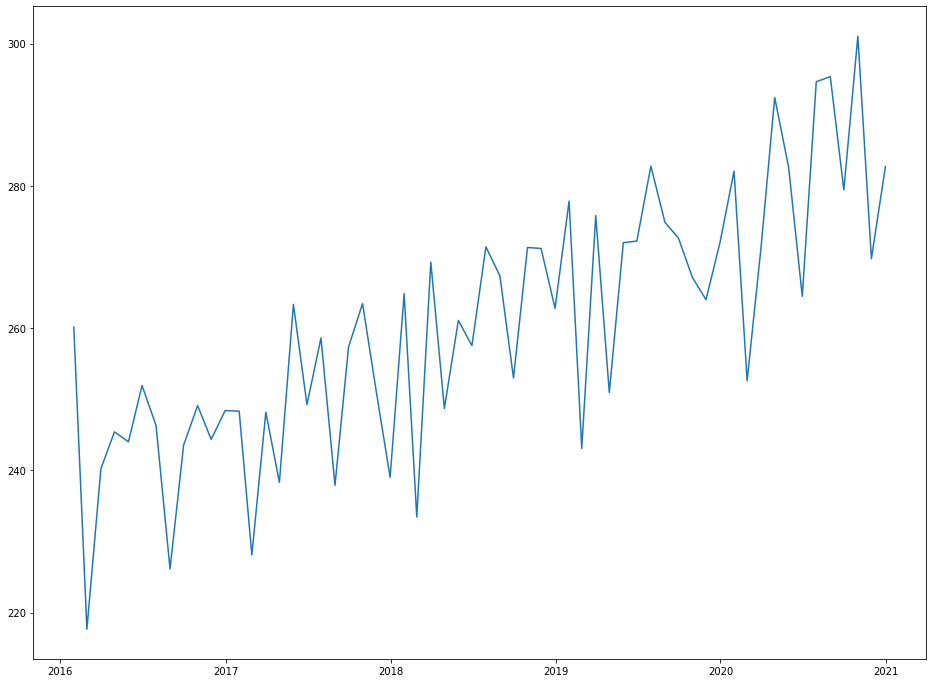

In [45]:
# Observed PMPM Plot

plt.rcParams['figure.figsize'] = [16, 12]
plt.plot(df_viz['date'], df_viz['pmpm'])

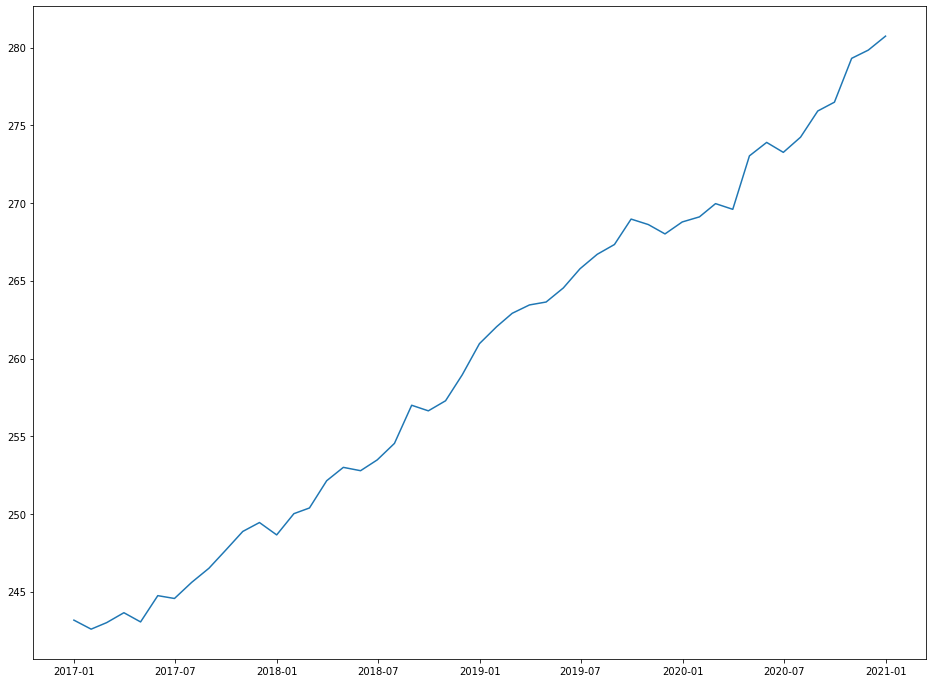

In [46]:
# Rolling 12 PMPM Plot

plt.plot(df_viz['date'], df_viz['pmpm_roll'])